In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [3]:
!pip install opendatasets

In [4]:
import os
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies'
od.download(dataset_url)
print("Dataset downloaded successfully using opendatasets!")
print("Kaggle data import setup code generated. Please uncomment and fill in your details.")
print("Remember to choose one method (e.g., opendatasets) and replace placeholders.")

Dataset URL: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies


100%|██████████| 247M/247M [00:00<00:00, 940MB/s] 



Dataset downloaded successfully using opendatasets!
Kaggle data import setup code generated. Please uncomment and fill in your details.
Remember to choose one method (e.g., opendatasets) and replace placeholders.


## DEEP LEARNING

# New Section

In [7]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_DIR = "/content/satellite-images-of-water-bodies/Water Bodies Dataset"
IMAGES_DIR = os.path.join(DATA_DIR, "Images")
MASKS_DIR = os.path.join(DATA_DIR, "Masks")

IMG_SIZE = 256
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using Device: {DEVICE}")

# (Optional) For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 2. DIAGONAL SPATIAL KALMAN FILTER
# ==========================================
class SpatialKalmanFilter(nn.Module):
    def __init__(self, channels):
        super(SpatialKalmanFilter, self).__init__()
        self.channels = channels

        self.F_net = nn.Sequential(
            nn.Linear(channels, channels),
            nn.Tanh()
        )
        self.Q_net = nn.Sequential(
            nn.Linear(channels, channels),
            nn.Sigmoid()
        )
        self.R_net = nn.Sequential(
            nn.Linear(channels, channels),
            nn.Sigmoid()
        )
        self.H_net = nn.Sequential(
            nn.Linear(channels, channels),
            nn.Tanh()
        )

    def forward(self, x):
        """
        x: [B, C, H, W]
        """
        b, c, h, w = x.shape
        x_seq = x.permute(0, 2, 3, 1)  # [B, H, W, C]

        state = torch.zeros(b, w, c, device=x.device)  # [B, W, C]
        P     = torch.ones(b, w, c, device=x.device)   # [B, W, C]

        output_rows = []

        for t in range(h):
            z = x_seq[:, t, :, :]  # [B, W, C]

            # Prediction
            F = self.F_net(state)
            Q = self.Q_net(state) * 0.1

            state_pred = state * F
            P_pred     = (P * (F ** 2)) + Q

            # Update
            R = self.R_net(z)
            H = self.H_net(z)

            y = z - (state_pred * H)          # innovation
            S = (P_pred * (H ** 2)) + R       # innovation covariance
            K = (P_pred * H) / (S + 1e-6)     # Kalman gain

            state_new = state_pred + K * y
            P_new     = (1 - K * H) * P_pred

            output_rows.append(state_new)

            state = state_new
            P     = P_new

        out = torch.stack(output_rows, dim=1)   # [B, H, W, C]
        out = out.permute(0, 3, 1, 2)          # [B, C, H, W]
        return out

# ==========================================
# 3. LKF-SEGNET MODEL
# ==========================================
class LKFSegNet(nn.Module):
    def __init__(self):
        super(LKFSegNet, self).__init__()

        self.unet = smp.Unet(
            encoder_name="mobilenet_v2",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1
        )

        bottleneck_channels = self.unet.encoder.out_channels[-1]
        self.lkf = SpatialKalmanFilter(channels=bottleneck_channels)

    def forward(self, x):
        features = self.unet.encoder(x)  # list/tuple
        features = list(features)
        features[-1] = self.lkf(features[-1])
        decoder_output = self.unet.decoder(features)
        masks = self.unet.segmentation_head(decoder_output)
        return masks

# ==========================================
# 4. EDGE-WEIGHTED LOSS
# ==========================================
class EdgeWeightedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, pred, target):
        # target: [B, 1, H, W]
        target_cpu = target.detach().cpu().numpy()
        weights = []

        for i in range(target_cpu.shape[0]):
            mask = (target_cpu[i, 0] * 255).astype(np.uint8)  # [H, W]
            edges = cv2.Canny(mask, 100, 200)
            dist = cv2.distanceTransform(255 - edges, cv2.DIST_L2, 5)
            # high weight near edges
            w_map = 1 + 4 * np.exp(-dist / 20.0)
            weights.append(w_map)

        weights = torch.tensor(np.array(weights)).unsqueeze(1).to(pred.device).float()
        loss = self.bce(pred, target)
        weighted_loss = (loss * weights).mean()
        return weighted_loss

# ==========================================
# 5. DATASET
# ==========================================
class WaterDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_ids=None, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        if image_ids is None:
            self.image_ids = sorted([f for f in os.listdir(images_dir)
                                     if f.lower().endswith('.jpg')])
        else:
            self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, i):
        img_name = self.image_ids[i]
        img_path = os.path.join(self.images_dir, img_name)

        possible_masks = [
            img_name,
            img_name.replace(".jpg", ".png"),
            img_name.replace(".jpeg", ".png"),
            img_name.replace(".JPG", ".png"),
            img_name.replace(".jpg", "_mask.png")
        ]
        mask_path = None
        for p in possible_masks:
            candidate = os.path.join(self.masks_dir, p)
            if os.path.exists(candidate):
                mask_path = candidate
                break

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if mask_path:
            # FIX: any non-zero pixel is treated as water (1), zero is background
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # [H, W]
            mask = (mask > 0).astype(np.float32)
        else:
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask)

        mask = mask.unsqueeze(0).float()  # [1, H, W]
        return image, mask

# ==========================================
# 6. TRANSFORMS
# ==========================================
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ==========================================
# 7. TRAIN / VAL / TEST SPLIT (70 / 15 / 15)
# ==========================================
all_image_ids = sorted([f for f in os.listdir(IMAGES_DIR)
                        if f.lower().endswith('.jpg')])
num_images = len(all_image_ids)

train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

train_size = int(train_ratio * num_images)
val_size   = int(val_ratio   * num_images)
test_size  = num_images - train_size - val_size

indices = torch.randperm(num_images)
train_indices = indices[:train_size].tolist()
val_indices   = indices[train_size:train_size + val_size].tolist()
test_indices  = indices[train_size + val_size:].tolist()

train_ids = [all_image_ids[i] for i in train_indices]
val_ids   = [all_image_ids[i] for i in val_indices]
test_ids  = [all_image_ids[i] for i in test_indices]

train_ds = WaterDataset(IMAGES_DIR, MASKS_DIR, image_ids=train_ids, transform=train_transform)
val_ds   = WaterDataset(IMAGES_DIR, MASKS_DIR, image_ids=val_ids,   transform=val_transform)
test_ds  = WaterDataset(IMAGES_DIR, MASKS_DIR, image_ids=test_ids,  transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=1,          shuffle=False, num_workers=2)

print(f"Data Loaded: {len(train_ds)} Train, {len(val_ds)} Val, {len(test_ds)} Test images.")

# Quick sanity check: water pixel percentage
total_ones = 0
total_pixels = 0
for _, mask in train_loader:
    m = mask.numpy()
    total_ones += (m > 0.5).sum()
    total_pixels += m.size
print("Percentage of water pixels in training masks:",
      100 * total_ones / total_pixels if total_pixels > 0 else 0.0)

# ==========================================
# 8. METRIC EVALUATION FUNCTION
# ==========================================
def evaluate_segmentation(model, loader, split_name="Split", threshold=0.5):
    model.eval()
    total_pixels = 0
    total_correct = 0
    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_gt_ones = 0
    total_pred_ones = 0

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc=f"Evaluating {split_name}"):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)  # [B,1,H,W]

            logits = model(imgs)      # [B,1,H,W]
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()

            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            total_pixels += masks_flat.numel()
            total_correct += (preds_flat == masks_flat).sum().item()

            gt_ones   = (masks_flat == 1).sum().item()
            pred_ones = (preds_flat == 1).sum().item()
            total_gt_ones += gt_ones
            total_pred_ones += pred_ones

            tp = ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            fp = ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            fn = ((preds_flat == 0) & (masks_flat == 1)).sum().item()

            total_tp += tp
            total_fp += fp
            total_fn += fn

    accuracy = total_correct / total_pixels if total_pixels > 0 else 0.0
    precision = total_tp / (total_tp + total_fp + 1e-7)
    recall    = total_tp / (total_tp + total_fn + 1e-7)
    iou       = total_tp / (total_tp + total_fp + total_fn + 1e-7)

    print(f"\n=== {split_name} Metrics ===")
    print(f"Percentage of pixels classified correctly (Accuracy): {accuracy*100:.2f}%")
    print(f"Overlap between predicted and actual water regions (IoU): {iou*100:.2f}%")
    print(f"Of the pixels labeled as water, how many are actually water? (Precision): {precision*100:.2f}%")
    print(f"Of all the actual water pixels, how many did you find? (Recall): {recall*100:.2f}%")
    print(f"[Debug] Total GT water pixels: {total_gt_ones}")
    print(f"[Debug] Total predicted water pixels: {total_pred_ones}")

    return {
        "accuracy": accuracy,
        "iou": iou,
        "precision": precision,
        "recall": recall,
        "tp": total_tp,
        "fp": total_fp,
        "fn": total_fn,
        "total_pixels": total_pixels,
        "gt_ones": total_gt_ones,
        "pred_ones": total_pred_ones,
    }

# ==========================================
# 9. TRAINING LOOP
# ==========================================
model = LKFSegNet().to(DEVICE)
criterion = EdgeWeightedLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

best_loss = float('inf')

print("\nStarting Training LKF-SegNet...")
print("-" * 30)

for epoch in range(EPOCHS):
    # Train
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, leave=True)
    for imgs, masks in loop:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}/{EPOCHS}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1} Summary: "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), "best_lkf_model.pth")
        print(">>> New Best Model Saved!")

print("Training Complete.")

# ==========================================
# 10. LOAD BEST MODEL & EVALUATE TRAIN / TEST
# ==========================================
best_model = LKFSegNet().to(DEVICE)
best_model.load_state_dict(torch.load("best_lkf_model.pth", map_location=DEVICE))
best_model.eval()
print("\nBest model loaded from best_lkf_model.pth")

train_metrics = evaluate_segmentation(best_model, train_loader, split_name="Train", threshold=0.5)
test_metrics  = evaluate_segmentation(best_model, test_loader,  split_name="Test",  threshold=0.5)


In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['val_iou'], label='Val IoU', color='green')
plt.title('Validation IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

###Evaluation

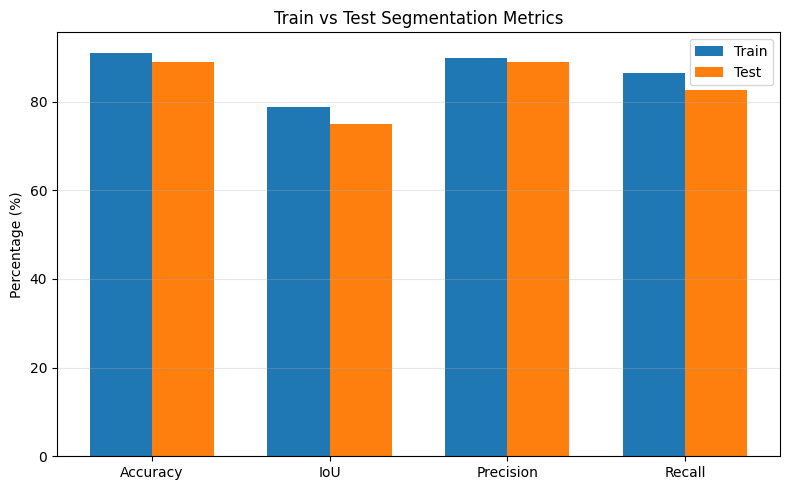

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# If you reran the notebook, recompute these:
# train_metrics = evaluate_segmentation(best_model, train_loader, split_name="Train", threshold=0.5)
# test_metrics  = evaluate_segmentation(best_model, test_loader,  split_name="Test",  threshold=0.5)

metrics = ["accuracy", "iou", "precision", "recall"]
train_vals = [train_metrics[m] for m in metrics]
test_vals  = [test_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, np.array(train_vals)*100, width, label="Train")
plt.bar(x + width/2, np.array(test_vals)*100,  width, label="Test")

plt.xticks(x, ["Accuracy", "IoU", "Precision", "Recall"])
plt.ylabel("Percentage (%)")
plt.title("Train vs Test Segmentation Metrics")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


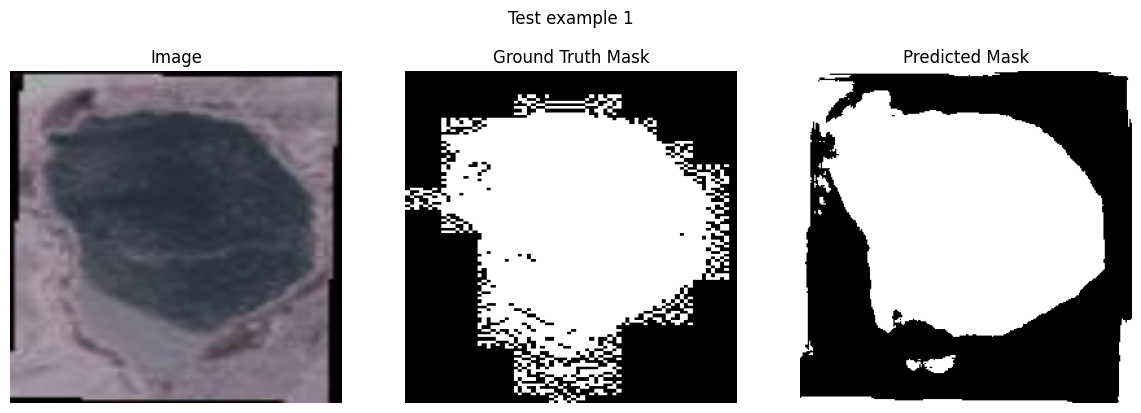

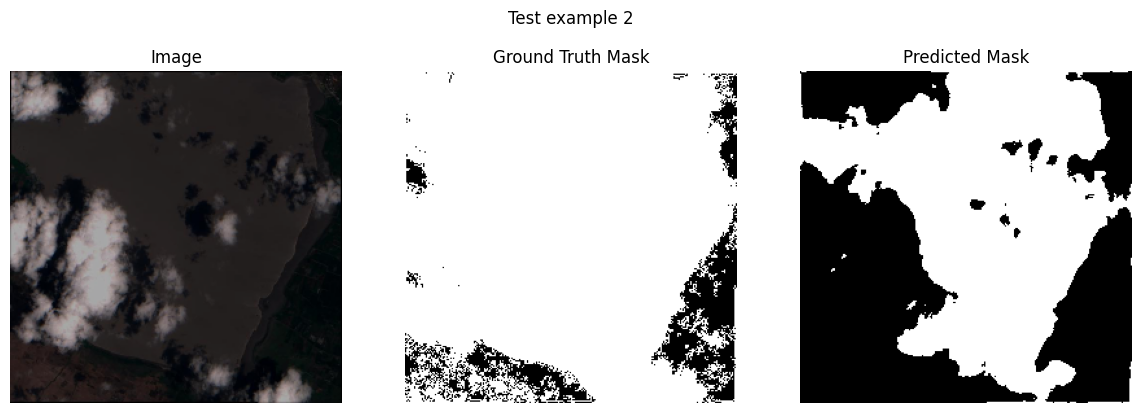

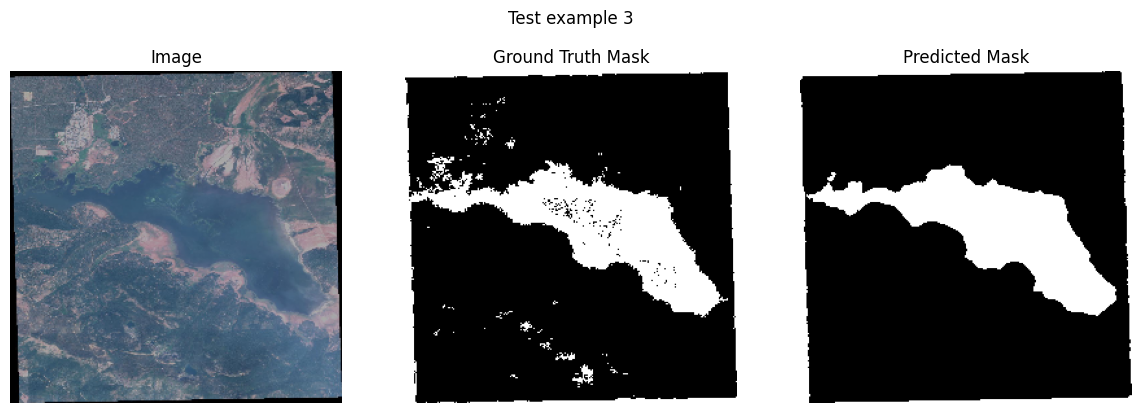

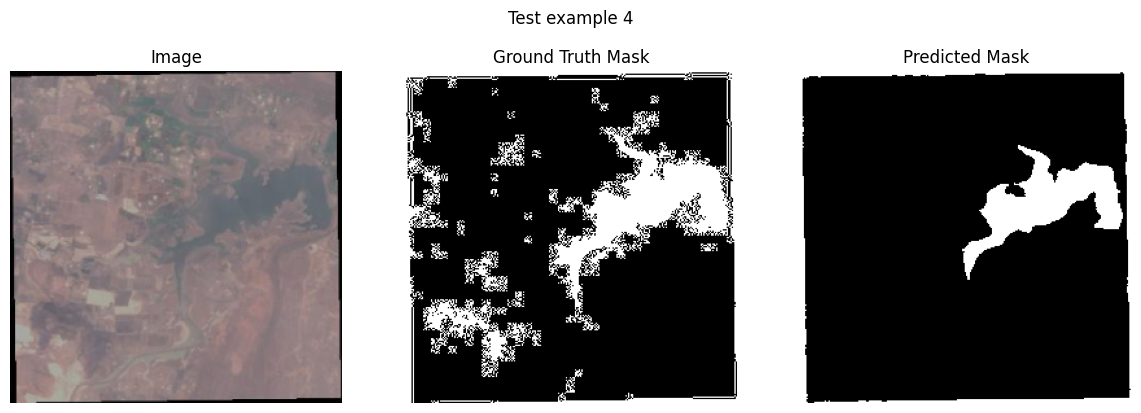

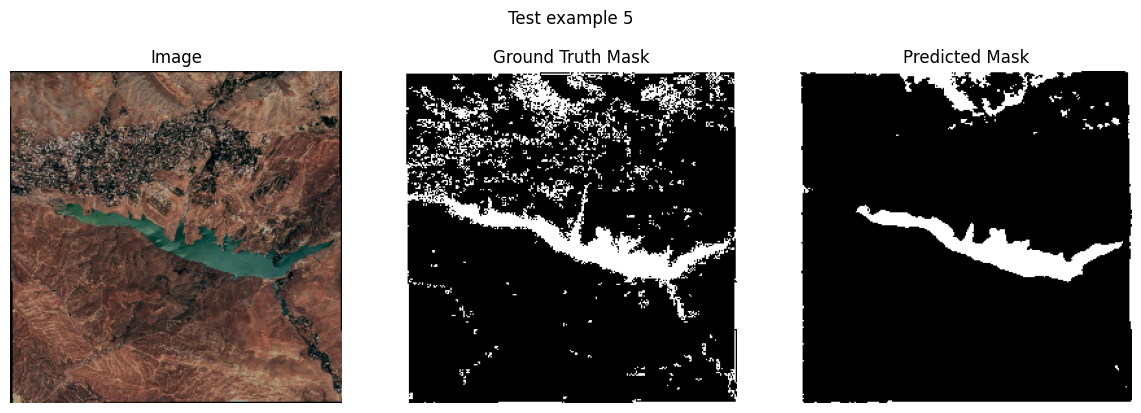

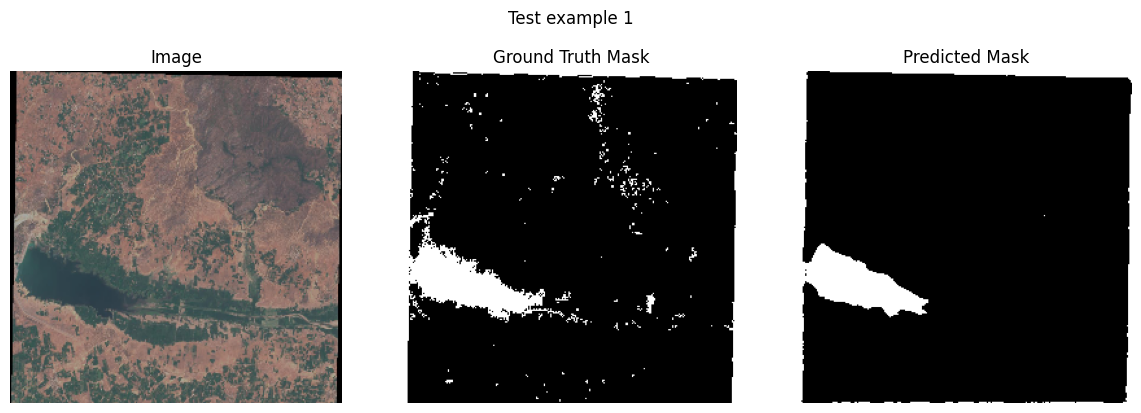

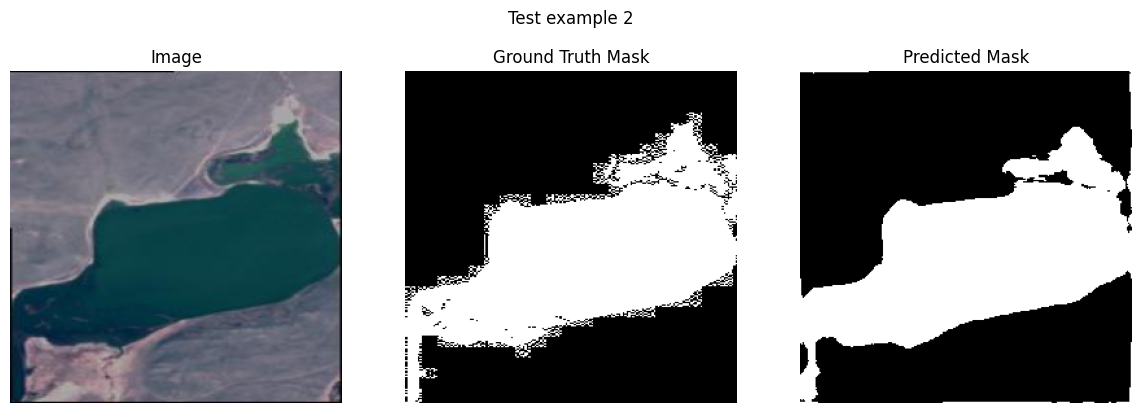

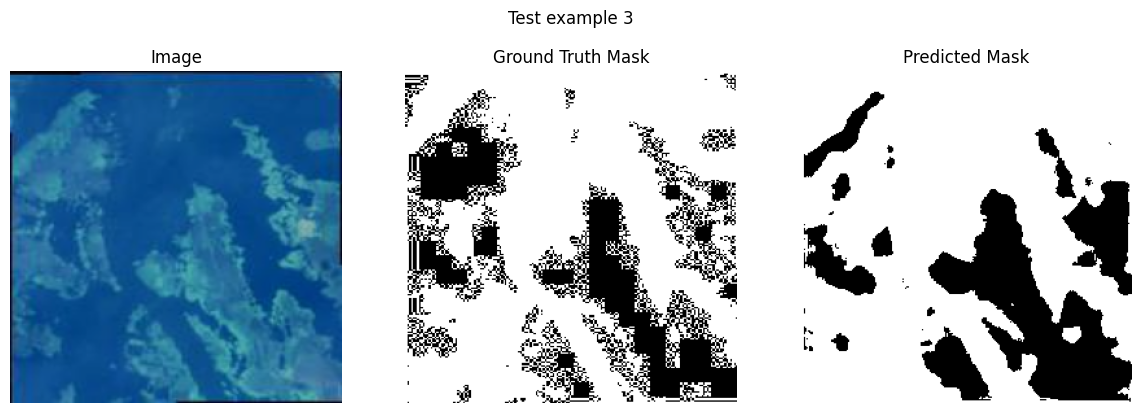

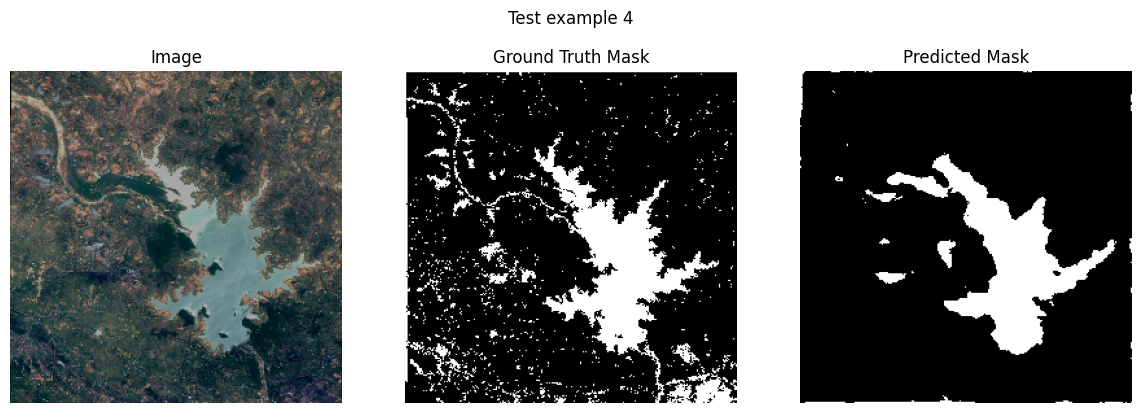

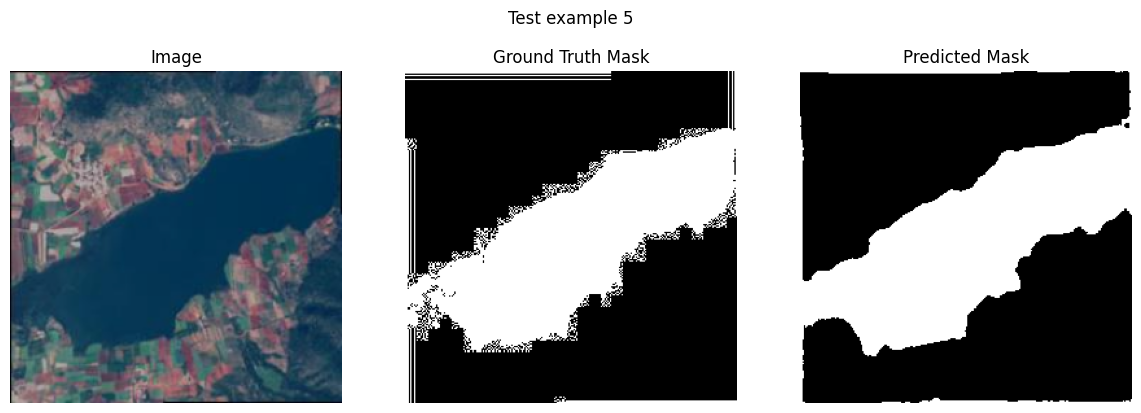

In [ ]:
import random
import matplotlib.pyplot as plt

# helper to un-normalize an image tensor
def unnormalize(img_tensor):
    # img_tensor: [3, H, W]
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

def show_predictions(model, loader, num_examples=5, threshold=0.5, split_name="Test"):
    model.eval()
    shown = 0

    # we convert loader to list so we can randomly pick indices
    data_list = list(loader)

    while shown < num_examples:
        # pick a random batch index and a random item within that batch
        batch_idx = random.randint(0, len(data_list)-1)
        imgs, masks = data_list[batch_idx]

        item_idx = random.randint(0, imgs.shape[0]-1)
        img = imgs[item_idx:item_idx+1].to(DEVICE)   # [1,3,H,W]
        mask = masks[item_idx]                       # [1,H,W]

        with torch.no_grad():
            logits = model(img)                      # [1,1,H,W]
            probs = torch.sigmoid(logits)
            pred = (probs > threshold).float()[0,0]  # [H,W]

        img_unnorm = unnormalize(img[0])

        gt_mask_np   = mask[0].cpu().numpy()
        pred_mask_np = pred.cpu().numpy()

        plt.figure(figsize=(12,4))
        plt.suptitle(f"{split_name} example {shown+1}", y=1.02)

        plt.subplot(1,3,1)
        plt.imshow(img_unnorm)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(gt_mask_np, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred_mask_np, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        shown += 1

# show 5 random test examples
show_predictions(best_model, test_loader, num_examples=5, threshold=0.5, split_name="Test")
import random
import matplotlib.pyplot as plt

# helper to un-normalize an image tensor
def unnormalize(img_tensor):
    # img_tensor: [3, H, W]
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

def show_predictions(model, loader, num_examples=5, threshold=0.5, split_name="Test"):
    model.eval()
    shown = 0

    # we convert loader to list so we can randomly pick indices
    data_list = list(loader)

    while shown < num_examples:
        # pick a random batch index and a random item within that batch
        batch_idx = random.randint(0, len(data_list)-1)
        imgs, masks = data_list[batch_idx]

        item_idx = random.randint(0, imgs.shape[0]-1)
        img = imgs[item_idx:item_idx+1].to(DEVICE)   # [1,3,H,W]
        mask = masks[item_idx]                       # [1,H,W]

        with torch.no_grad():
            logits = model(img)                      # [1,1,H,W]
            probs = torch.sigmoid(logits)
            pred = (probs > threshold).float()[0,0]  # [H,W]

        img_unnorm = unnormalize(img[0])

        gt_mask_np   = mask[0].cpu().numpy()
        pred_mask_np = pred.cpu().numpy()

        plt.figure(figsize=(12,4))
        plt.suptitle(f"{split_name} example {shown+1}", y=1.02)

        plt.subplot(1,3,1)
        plt.imshow(img_unnorm)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(gt_mask_np, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred_mask_np, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        shown += 1

# show 5 random test examples
show_predictions(best_model, test_loader, num_examples=5, threshold=0.5, split_name="Test")


Per-image IoU: 100%|██████████| 427/427 [00:11<00:00, 36.97it/s]


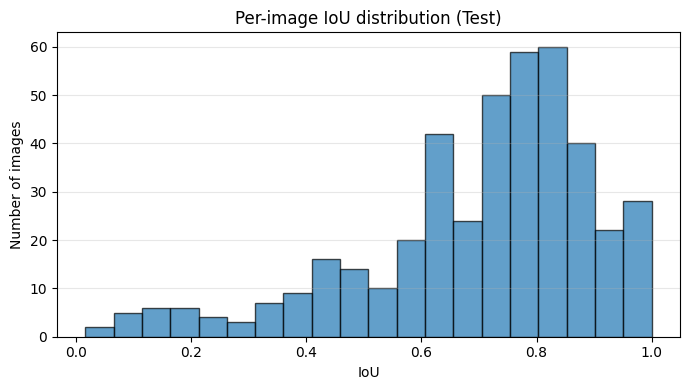

Mean IoU: 0.7003, Median IoU: 0.7471


In [ ]:
def per_image_iou_distribution(model, loader, threshold=0.5):
    model.eval()
    ious = []

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Per-image IoU"):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)  # [B,1,H,W]

            logits = model(imgs)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()

            # flatten per image
            B = masks.shape[0]
            for b in range(B):
                p = preds[b].view(-1)
                g = masks[b].view(-1)
                tp = ((p == 1) & (g == 1)).sum().item()
                fp = ((p == 1) & (g == 0)).sum().item()
                fn = ((p == 0) & (g == 1)).sum().item()
                iou = tp / (tp + fp + fn + 1e-7)
                ious.append(iou)

    ious = np.array(ious)
    plt.figure(figsize=(7,4))
    plt.hist(ious, bins=20, edgecolor="black", alpha=0.7)
    plt.title("Per-image IoU distribution (Test)")
    plt.xlabel("IoU")
    plt.ylabel("Number of images")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"Mean IoU: {ious.mean():.4f}, Median IoU: {np.median(ious):.4f}")

per_image_iou_distribution(best_model, test_loader, threshold=0.5)


Predicting mask for: /content/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_100.jpg


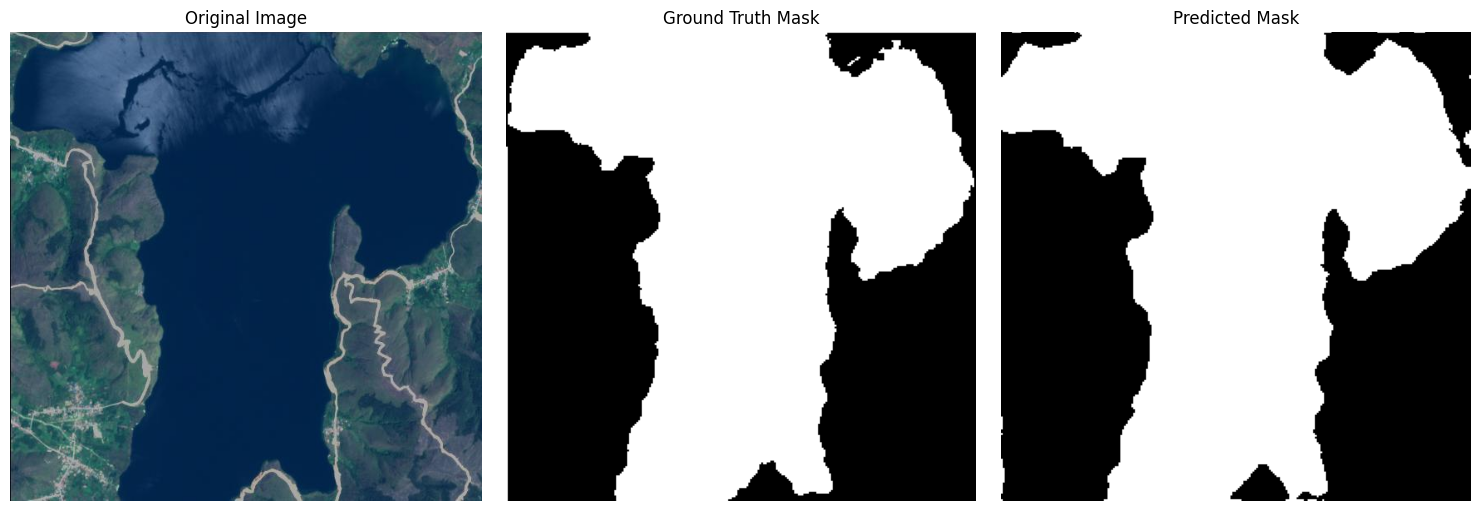

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

# --- Configuration for single image prediction ---
SINGLE_IMAGE_PATH = "/content/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_100.jpg"
SINGLE_MASK_PATH = "/content/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/water_body_100.jpg" # Adjust if mask has .png extension or different naming

def predict_single_image(model, image_path, mask_path=None, transform=None, device='cuda', threshold=0.5):
    model.eval()

    # 1. Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load ground truth mask if provided
    gt_mask_np = None
    if mask_path and os.path.exists(mask_path):
        gt_mask_np = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt_mask_np = (gt_mask_np > 127).astype(np.float32)
    else:
        print(f"Warning: Ground truth mask not found at {mask_path}")

    # Apply the same validation transformations
    if transform:
        # Albumentations expects (H, W, C) for image and (H, W) for mask
        # We apply image transform and then manual mask resize/conversion if needed
        transformed = transform(image=image)
        input_image = transformed["image"].unsqueeze(0).to(device) # Add batch dimension
    else:
        # If no transform, resize manually and normalize
        image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        input_image = torch.from_numpy(image_resized.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)

    # 2. Make prediction
    with torch.no_grad():
        logits = model(input_image)
        probabilities = torch.sigmoid(logits)
        predicted_mask = (probabilities > threshold).float()

    # Move to CPU and convert to numpy for visualization
    predicted_mask_np = predicted_mask.squeeze().cpu().numpy()

    # If ground truth mask was loaded, resize it to match prediction output size
    if gt_mask_np is not None:
        gt_mask_np = cv2.resize(gt_mask_np, (predicted_mask_np.shape[1], predicted_mask_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 3. Visualize results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image) # Original image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    if gt_mask_np is not None:
        plt.imshow(gt_mask_np, cmap='gray')
        plt.title('Ground Truth Mask')
    else:
        plt.title('No Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_np, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Run prediction for a single image ---
# Ensure best_model and val_transform are defined from previous cells
if 'best_model' in locals() and 'val_transform' in locals():
    print(f"Predicting mask for: {SINGLE_IMAGE_PATH}")
    predict_single_image(best_model, SINGLE_IMAGE_PATH, SINGLE_MASK_PATH, val_transform, DEVICE)
else:
    print("Error: 'best_model' or 'val_transform' not found. Please ensure previous training cells have been run.")

In [ ]:
# Check mask distribution
import numpy as np

total_ones = 0
total_pixels = 0

for _, mask in train_loader:
    m = mask.numpy()
    total_ones += (m == 1).sum()
    total_pixels += m.size

print("Percentage of water pixels in training masks:",
      100 * total_ones / total_pixels)


Percentage of water pixels in training masks: 38.406706719811055


### MOdule 2

Using device: cuda
Loaded trained LKFSegNet from /content/best_lkf_model.pth


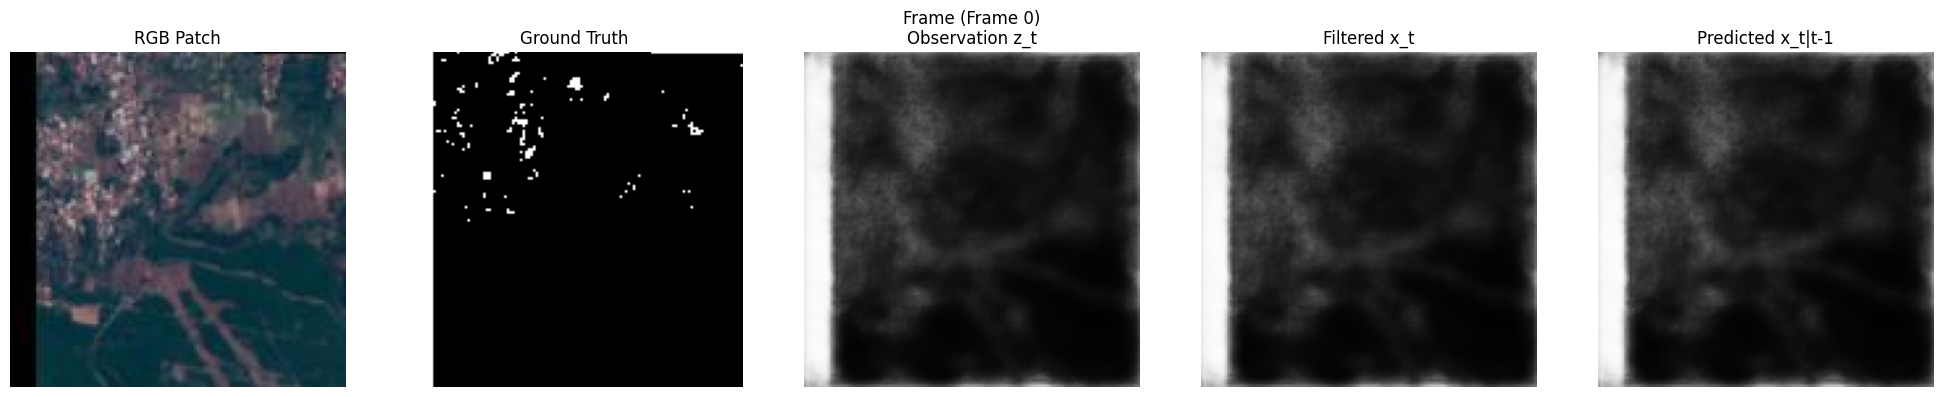

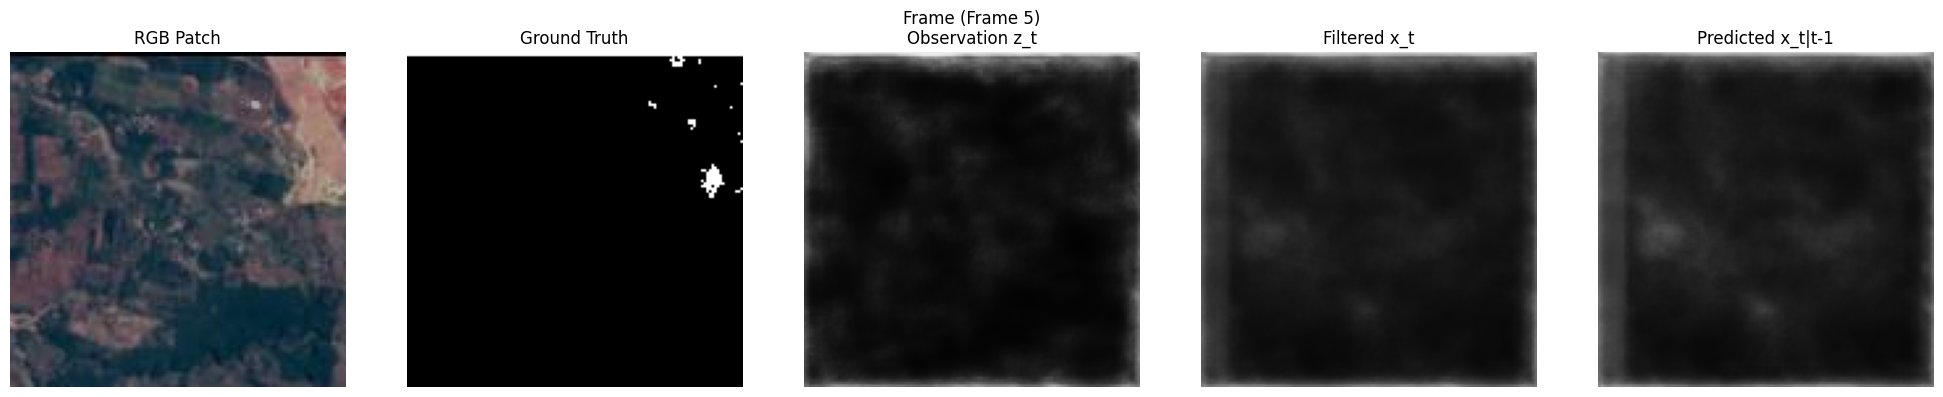

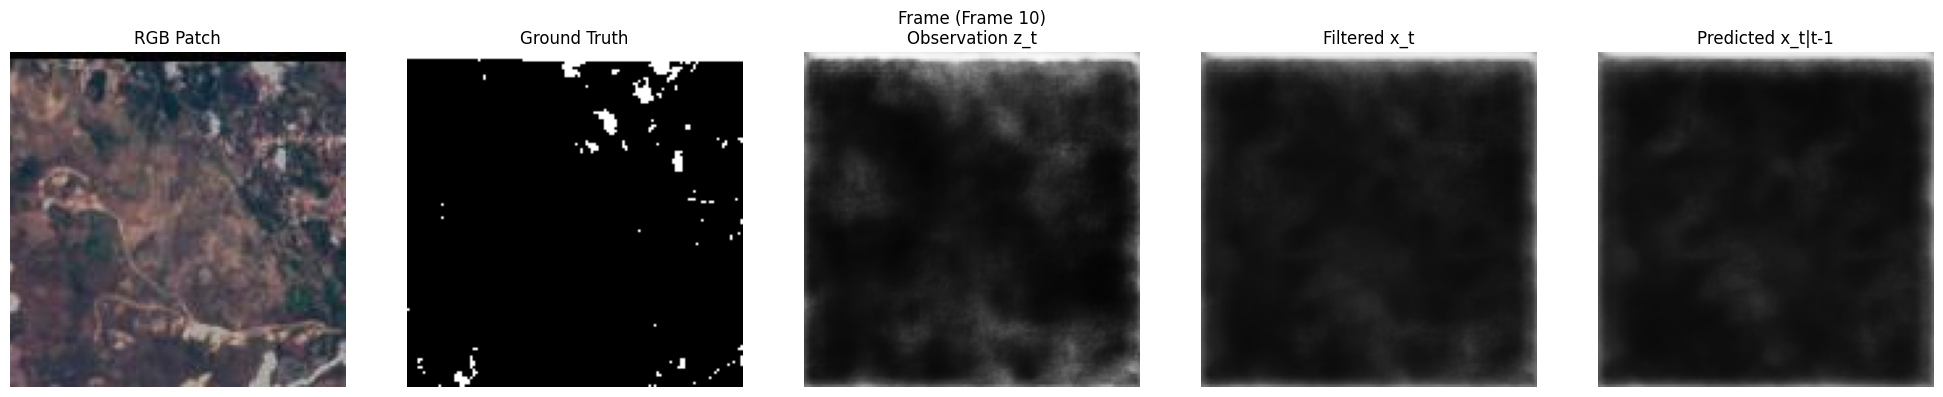

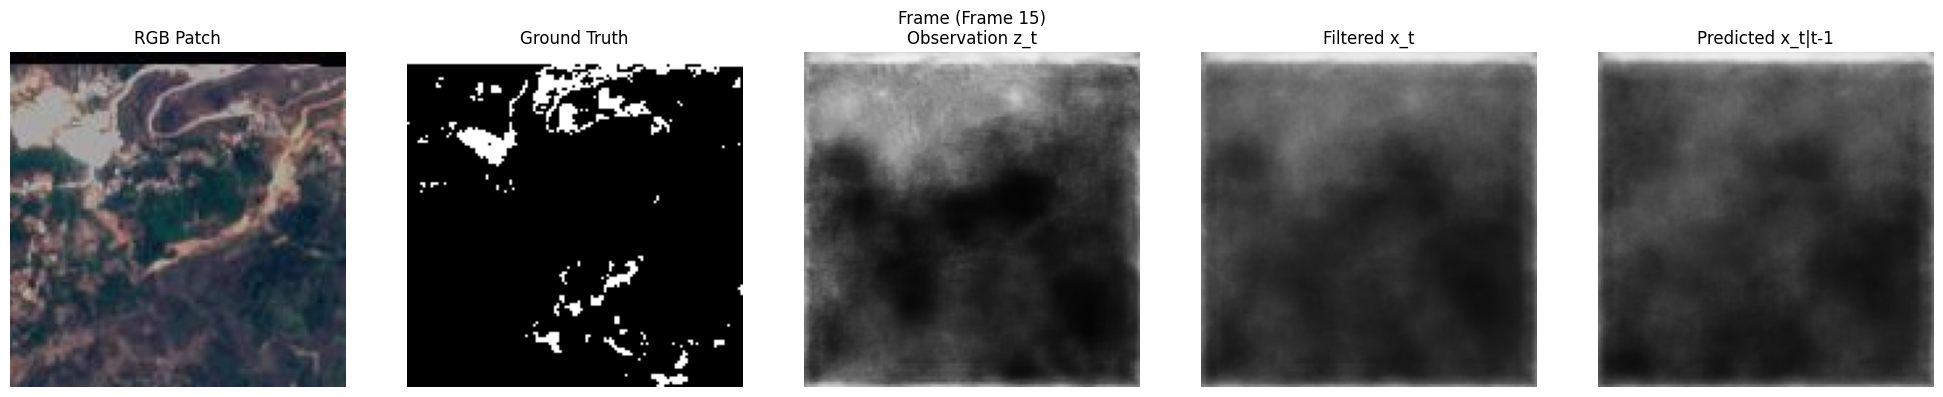

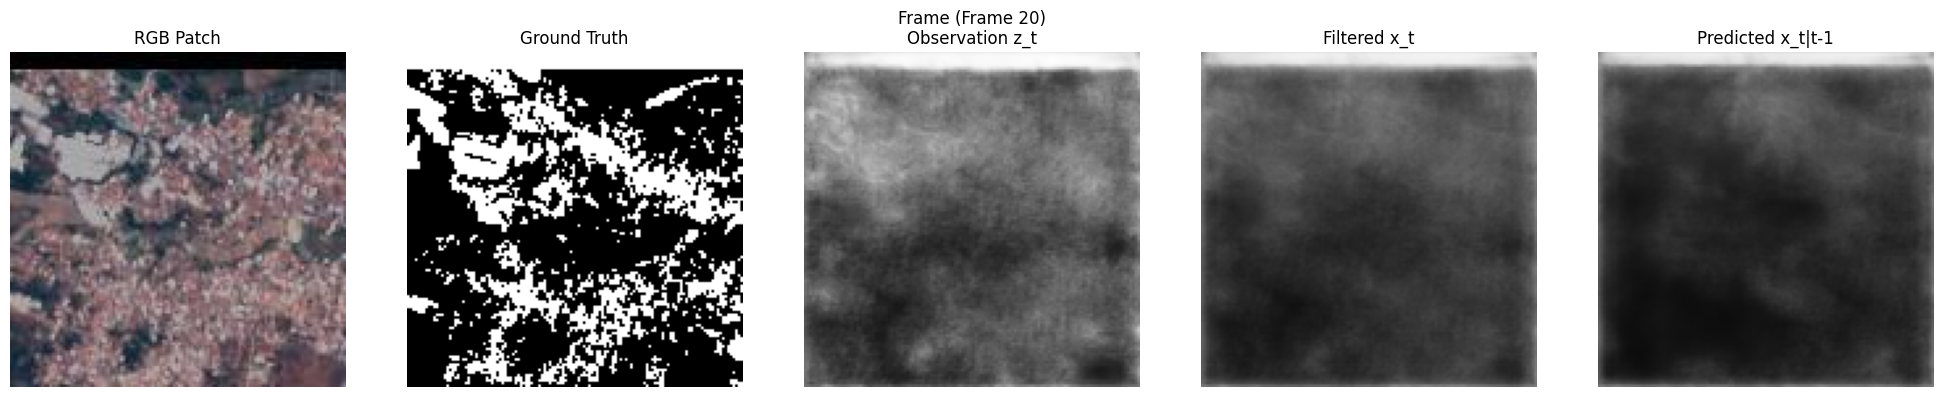


Prediction / Filtering Statistics:
Observation MAE: 0.2181
Filtered MAE:    0.2616
Prediction MAE:  0.2861


In [8]:
"""
Integrated LKF-SegNet + Temporal Kalman Filter (Prediction-focused)
===================================================================
Use your trained LKF-SegNet (best_lkf_model.pth) to generate observation masks
for a synthetic temporal sequence (sliding window over a single image), and
apply a temporal Kalman filter to (1) filter and (2) PREDICT the next mask.

Run this AFTER you have trained and saved best_lkf_model.pth.
"""

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torchvision.transforms as T
import segmentation_models_pytorch as smp

# ============================================================================
# CONFIGURATION
# ============================================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Path to your trained weights
MODEL_WEIGHTS_PATH = "/content/best_lkf_model.pth"

# Patch extraction settings
PATCH_SIZE = (128, 128)
STRIDE = 64

# Kalman filter parameters
PROCESS_VAR = 0.01
OBS_VAR = 0.05

SAMPLE_FRAMES = [0, 5, 10, 15, 20]

# ============================================================================
# 0. MODEL ARCHITECTURE
# ============================================================================

class SpatialKalmanFilter(nn.Module):
    def __init__(self, channels):
        super(SpatialKalmanFilter, self).__init__()
        self.channels = channels

        self.F_net = nn.Sequential(nn.Linear(channels, channels), nn.Tanh())
        self.Q_net = nn.Sequential(nn.Linear(channels, channels), nn.Sigmoid())
        self.R_net = nn.Sequential(nn.Linear(channels, channels), nn.Sigmoid())
        self.H_net = nn.Sequential(nn.Linear(channels, channels), nn.Tanh())

    def forward(self, x):
        b, c, h, w = x.shape
        x_seq = x.permute(0, 2, 3, 1)

        state = torch.zeros(b, w, c, device=x.device)
        P = torch.ones(b, w, c, device=x.device)

        output_rows = []

        for t in range(h):
            z = x_seq[:, t, :, :]

            F = self.F_net(state)
            Q = self.Q_net(state) * 0.1

            state_pred = state * F
            P_pred = (P * (F ** 2)) + Q

            R = self.R_net(z)
            H = self.H_net(z)

            y = z - (state_pred * H)
            S = (P_pred * (H ** 2)) + R
            K = (P_pred * H) / (S + 1e-6)

            state_new = state_pred + K * y
            P_new = (1 - K * H) * P_pred

            output_rows.append(state_new)
            state, P = state_new, P_new

        out = torch.stack(output_rows, dim=1)
        return out.permute(0, 3, 1, 2)


class LKFSegNet(nn.Module):
    def __init__(self):
        super(LKFSegNet, self).__init__()

        self.unet = smp.Unet(
            encoder_name="mobilenet_v2",
            encoder_weights=None,
            in_channels=3,
            classes=1
        )

        bottleneck_channels = self.unet.encoder.out_channels[-1]
        self.lkf = SpatialKalmanFilter(bottleneck_channels)

    def forward(self, x):
        features = list(self.unet.encoder(x))
        features[-1] = self.lkf(features[-1])
        decoder_output = self.unet.decoder(features)
        return self.unet.segmentation_head(decoder_output)


def load_trained_lkf_model(weights_path, device="cuda"):
    model = LKFSegNet().to(device)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()
    print(f"Loaded trained LKFSegNet from {weights_path}")
    return model


# ============================================================================
# 1. SYNTHETIC VIDEO CREATION
# ============================================================================

def extract_patches(image, patch_size, stride):
    h, w = image.shape[:2]
    ph, pw = patch_size
    patches, coords = [], []

    for top in range(0, h - ph + 1, stride):
        for left in range(0, w - pw + 1, stride):
            patches.append(image[top:top+ph, left:left+pw])
            coords.append((top, left))

    return patches, coords


def extract_mask_patches(mask, patch_size, stride):
    h, w = mask.shape[:2]
    ph, pw = patch_size
    patches = []

    for top in range(0, h - ph + 1, stride):
        for left in range(0, w - pw + 1, stride):
            patches.append(mask[top:top+ph, left:left+pw])

    return patches


# ============================================================================
# 2. OBSERVATION GENERATION USING LKF-SEgNet
# ============================================================================

patch_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_mask_from_model(model, img_patch, device="cuda"):
    t = patch_transform(img_patch).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(t)
        probs = torch.sigmoid(logits)[0, 0]
    return probs.cpu().numpy().astype(np.float32)


def real_segmentation_sequence(model, img_patches, device="cuda"):
    T = len(img_patches)
    h, w = img_patches[0].shape[:2]
    seq = np.zeros((T, h, w), dtype=np.float32)

    for t, patch in enumerate(img_patches):
        seq[t] = predict_mask_from_model(model, patch, device)

    return seq


# ============================================================================
# 3. TEMPORAL KALMAN FILTER
# ============================================================================

def kalman_filter_masks(z_seq, process_var=0.01, obs_var=0.05):
    T, h, w = z_seq.shape
    x_filtered = np.zeros((T, h, w))
    x_pred_next = np.zeros((T, h, w))

    x = z_seq[0].copy()
    P = np.ones((h, w)) * obs_var

    for t in range(T):
        x_pred = x.copy()
        P_pred = P + process_var
        x_pred_next[t] = x_pred

        K = P_pred / (P_pred + obs_var)
        innovation = z_seq[t] - x_pred

        x = x_pred + K * innovation
        P = (1 - K) * P_pred

        x_filtered[t] = np.clip(x, 0, 1)

    return x_filtered, x_pred_next


# ============================================================================
# 4. VISUALIZATION (RAW PROBABILITY MASKS)
# ============================================================================

def show_frame(img_patch, gt_patch, obs_mask, kf_mask, pred_mask, title="Frame", frame_idx=None):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    if frame_idx is not None:
        title += f" (Frame {frame_idx})"
    fig.suptitle(title)

    axes[0].imshow(img_patch)
    axes[0].set_title("RGB Patch")

    axes[1].imshow(gt_patch, cmap="gray")
    axes[1].set_title("Ground Truth")

    axes[2].imshow(obs_mask, cmap="gray", vmin=0, vmax=1)
    axes[2].set_title("Observation z_t")

    axes[3].imshow(kf_mask, cmap="gray", vmin=0, vmax=1)
    axes[3].set_title("Filtered x_t")

    axes[4].imshow(pred_mask, cmap="gray", vmin=0, vmax=1)
    axes[4].set_title("Predicted x_t|t-1")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# ============================================================================
# 5. METRICS (MAE-BASED)
# ============================================================================

def evaluate_prediction_statistics(obs_masks, filt_masks, pred_masks, gt_patches):
    gt = np.array(gt_patches)

    obs_mae = np.mean(np.abs(obs_masks - gt), axis=(1,2))
    filt_mae = np.mean(np.abs(filt_masks - gt), axis=(1,2))
    pred_mae = np.mean(np.abs(pred_masks[1:] - gt[1:]), axis=(1,2))

    print("\nPrediction / Filtering Statistics:")
    print(f"Observation MAE: {obs_mae.mean():.4f}")
    print(f"Filtered MAE:    {filt_mae.mean():.4f}")
    print(f"Prediction MAE:  {pred_mae.mean():.4f}")


# ============================================================================
# 6. MAIN
# ============================================================================

def main():
    IMAGE_PATH = "/content/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1.jpg"
    MASK_PATH  = "/content/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/water_body_1.jpg"

    image = cv2.cvtColor(cv2.imread(IMAGE_PATH), cv2.COLOR_BGR2RGB)
    mask = (cv2.imread(MASK_PATH, cv2.IMREAD_GRAYSCALE) > 127).astype(np.float32)

    img_patches, _ = extract_patches(image, PATCH_SIZE, STRIDE)
    mask_patches = extract_mask_patches(mask, PATCH_SIZE, STRIDE)

    model = load_trained_lkf_model(MODEL_WEIGHTS_PATH, DEVICE)
    z_seq = real_segmentation_sequence(model, img_patches, DEVICE)

    x_filt, x_pred = kalman_filter_masks(z_seq)

    for idx in SAMPLE_FRAMES:
        show_frame(img_patches[idx], mask_patches[idx], z_seq[idx], x_filt[idx], x_pred[idx], frame_idx=idx)

    evaluate_prediction_statistics(z_seq, x_filt, x_pred, mask_patches)


if __name__ == "__main__":
    main()


Using device: cuda

TEMPORAL KALMAN FILTER WITH TRAINED LKF-SegNet (PREDICTION MODE)

[STEP 1] Loading image and mask...
  Loaded image: (2009, 2007, 3)
  Loaded mask: (2009, 2007)
  Water pixels: 12.97%

[STEP 2] Extracting patches (synthetic temporal sequence)...
Extracted 900 patches from image of size (2009, 2007)
Patch size: (128, 128), Stride: 64
Extracted 900 mask patches
  Total frames: 900

[STEP 3] Loading trained LKFSegNet and generating observation masks...
Loaded trained LKFSegNet from /content/best_lkf_model.pth
Generating observation masks from real LKFSegNet for 900 patches...
Done generating observation masks.
  Observation sequence shape: (900, 128, 128)

[STEP 4] Applying temporal Kalman filter...
Running Kalman filter on 900 frames of size (128, 128)...
Kalman filtering complete! Q=0.01, R=0.05
  Filtered sequence shape:   (900, 128, 128)
  Prediction sequence shape: (900, 128, 128)

[STEP 5] Visualizing sample frames (including predictions)...


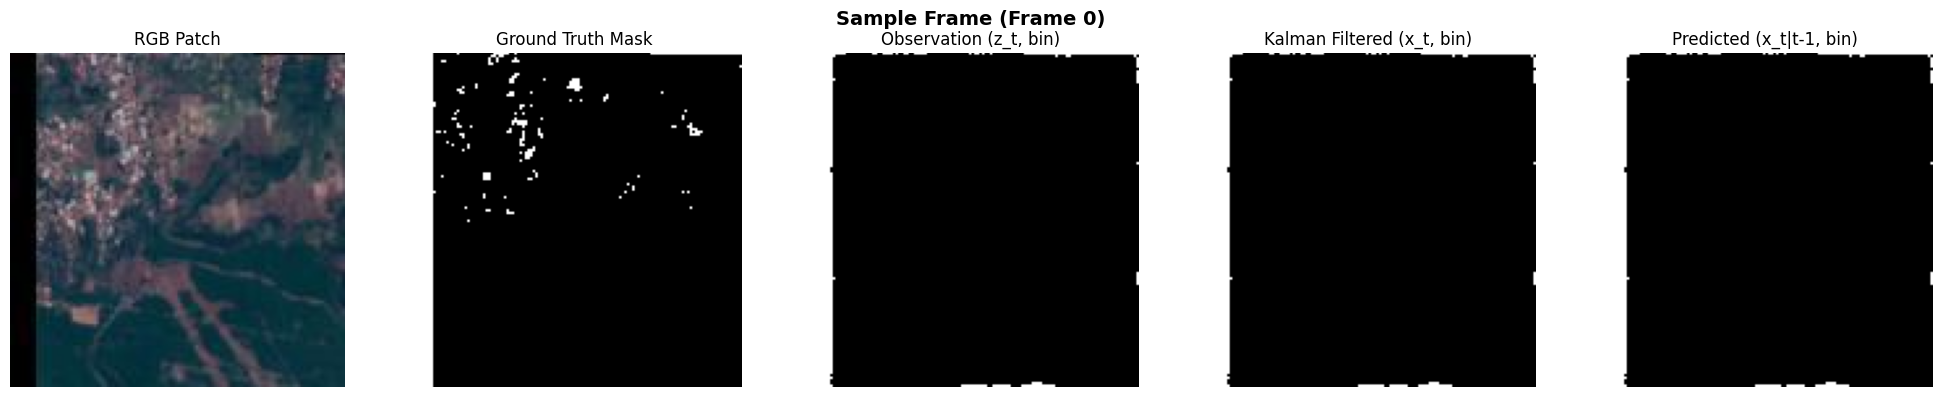

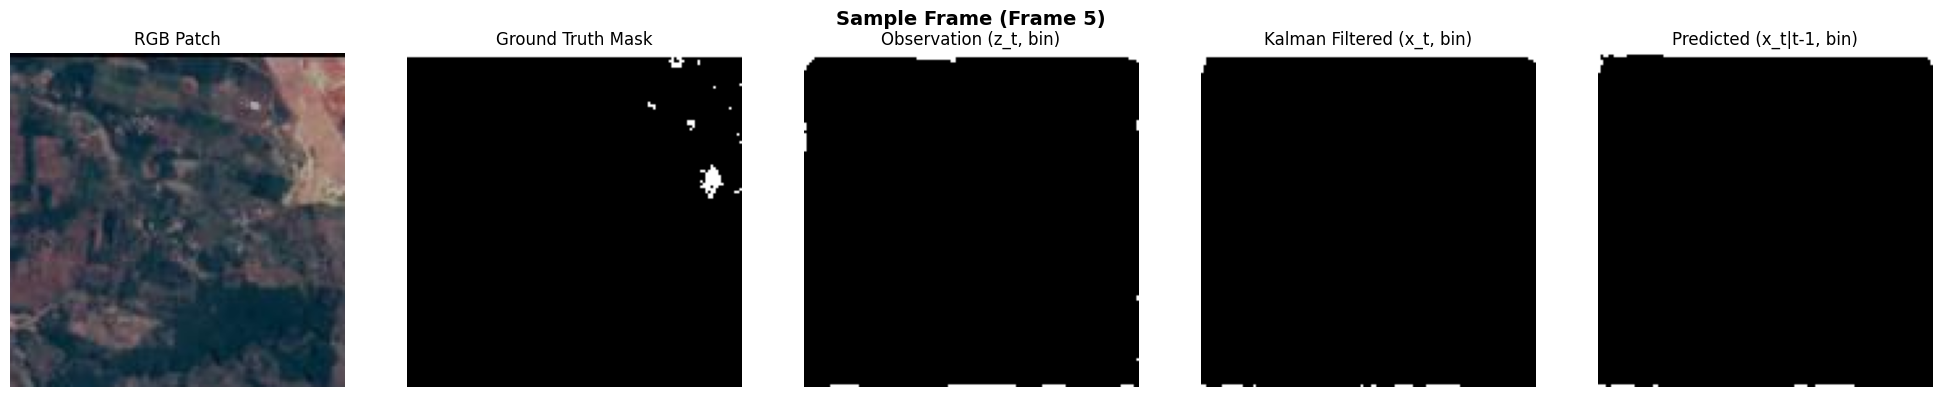

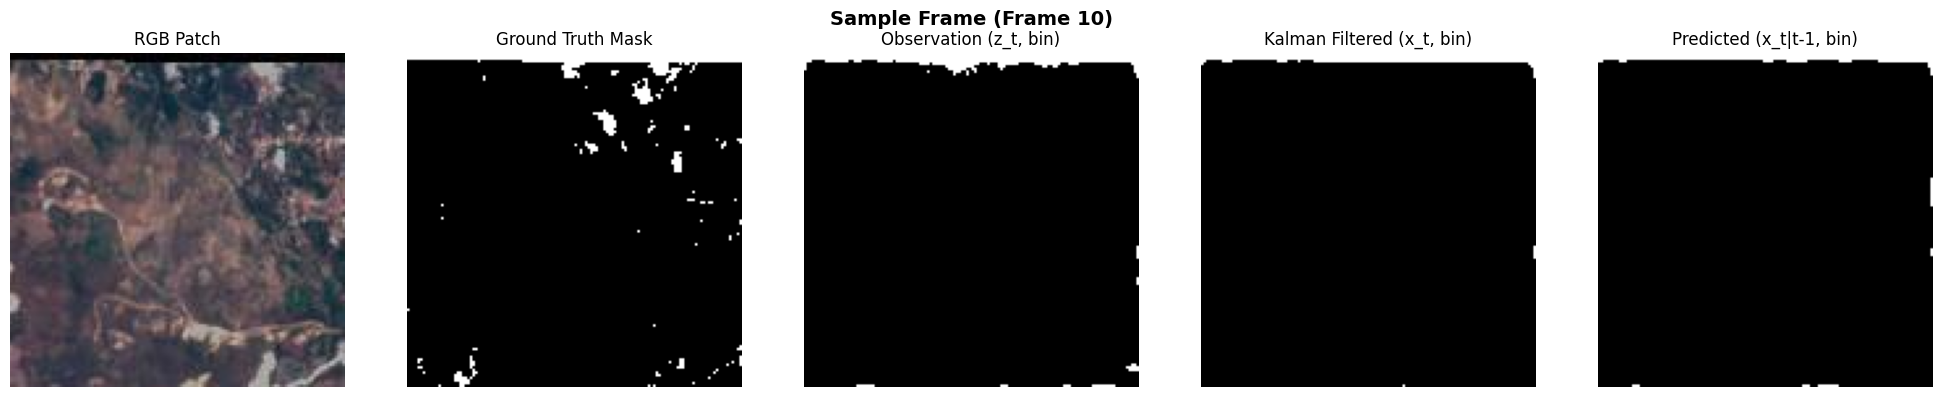

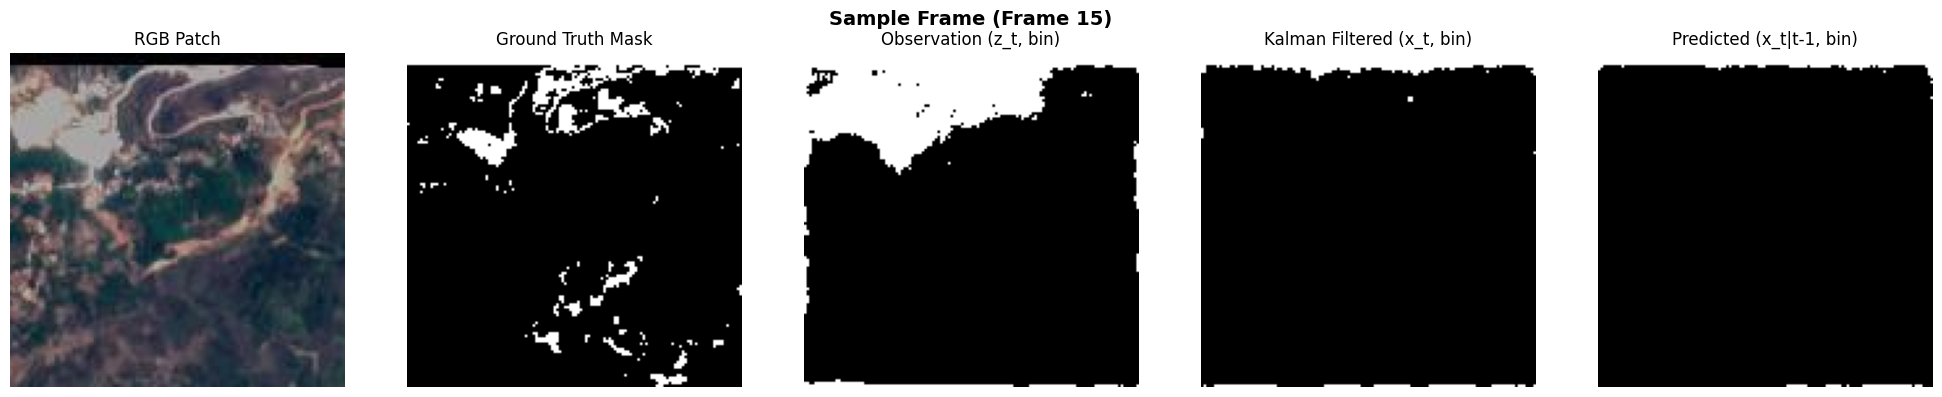

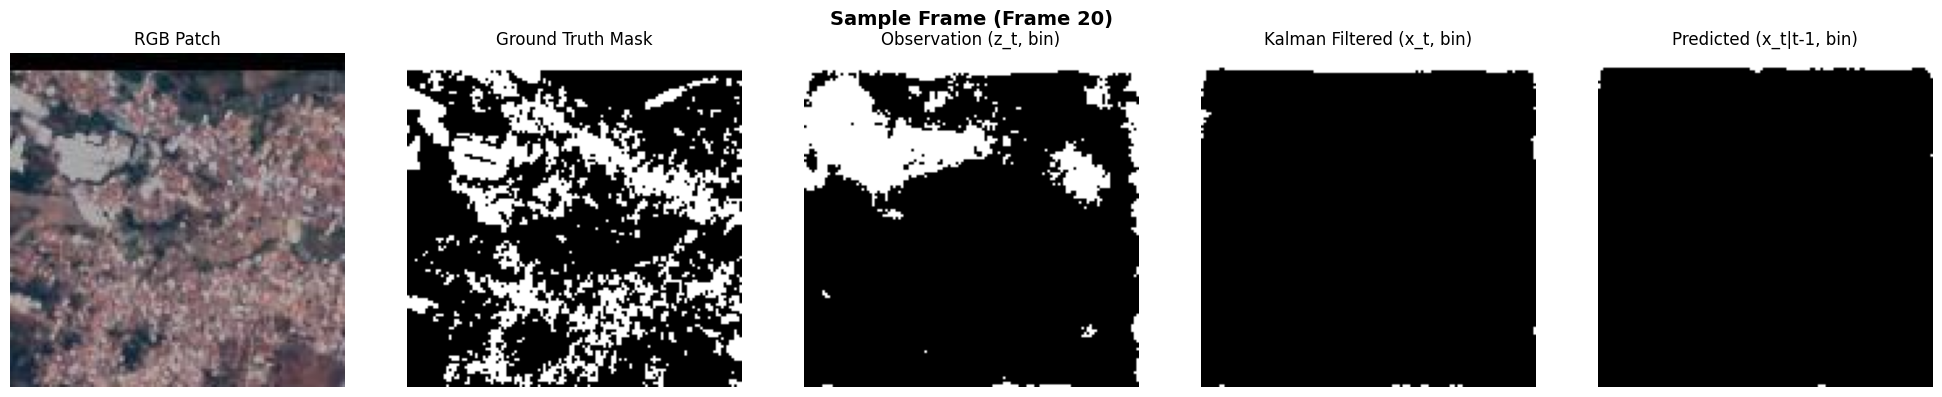


Evaluating prediction vs ground truth...

PREDICTION / FILTERING STATISTICS (MAE vs GT)
Observation (z_t):
  Mean MAE: 0.2181  ± 0.1061
Filtered (x_t):
  Mean MAE: 0.2616 ± 0.1154
Predicted (x_t|t-1): [t>=1]
  Mean MAE: 0.2861 ± 0.1360


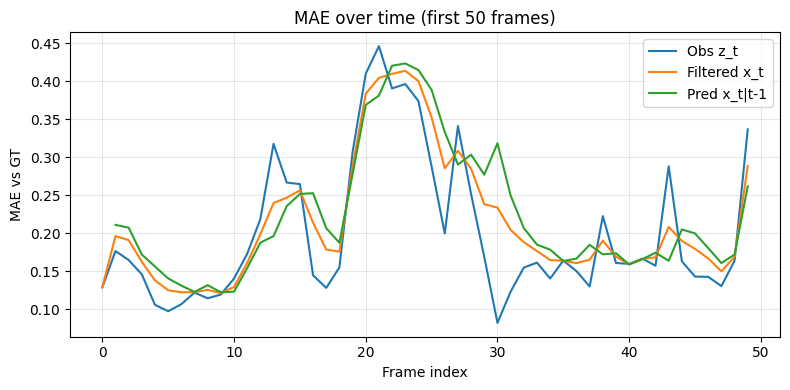


PIPELINE COMPLETE! (Prediction-focused)


In [ ]:
"""
improved visualization by binarizing masks before plotting + a cleaner weight path
"""

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torchvision.transforms as T
import segmentation_models_pytorch as smp

# ============================================================================
# CONFIGURATION
# ============================================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Path to your trained weights
MODEL_WEIGHTS_PATH = "/content/best_lkf_model.pth"   # <-- change if needed

# Patch extraction settings
PATCH_SIZE = (128, 128)  # (height, width)
STRIDE = 64

# Kalman filter parameters
PROCESS_VAR = 0.01  # Process noise variance (Q)
OBS_VAR = 0.05      # Observation noise variance (R)

# Visualization settings
SAMPLE_FRAMES = [0, 5, 10, 15, 20]  # Frame indices to visualize
NUM_ANIMATION_FRAMES = 20

# ============================================================================
# 0. YOUR MODEL ARCHITECTURE (COPIED FROM YOUR TRAINING SCRIPT)
# ============================================================================

class SpatialKalmanFilter(nn.Module):
    def __init__(self, channels):
        super(SpatialKalmanFilter, self).__init__()
        self.channels = channels

        self.F_net = nn.Sequential(
            nn.Linear(channels, channels),
            nn.Tanh()
        )
        self.Q_net = nn.Sequential(
            nn.Linear(channels, channels),
            nn.Sigmoid()
        )
        self.R_net = nn.Sequential(
            nn.Linear(channels, channels),
            nn.Sigmoid()
        )
        self.H_net = nn.Sequential(
            nn.Linear(channels, channels),
            nn.Tanh()
        )

    def forward(self, x):
        """
        x: [B, C, H, W]
        """
        b, c, h, w = x.shape
        x_seq = x.permute(0, 2, 3, 1)  # [B, H, W, C]

        state = torch.zeros(b, w, c, device=x.device)  # [B, W, C]
        P     = torch.ones(b, w, c, device=x.device)   # [B, W, C]

        output_rows = []

        for t in range(h):
            z = x_seq[:, t, :, :]  # [B, W, C]

            # Prediction
            F = self.F_net(state)
            Q = self.Q_net(state) * 0.1

            state_pred = state * F
            P_pred     = (P * (F ** 2)) + Q

            # Update
            R = self.R_net(z)
            H = self.H_net(z)

            y = z - (state_pred * H)          # innovation
            S = (P_pred * (H ** 2)) + R       # innovation covariance
            K = (P_pred * H) / (S + 1e-6)     # Kalman gain

            state_new = state_pred + K * y
            P_new     = (1 - K * H) * P_pred

            output_rows.append(state_new)

            state = state_new
            P     = P_new

        out = torch.stack(output_rows, dim=1)   # [B, H, W, C]
        out = out.permute(0, 3, 1, 2)          # [B, C, H, W]
        return out


class LKFSegNet(nn.Module):
    def __init__(self):
        super(LKFSegNet, self).__init__()

        self.unet = smp.Unet(
            encoder_name="mobilenet_v2",
            encoder_weights=None,  # weights will be loaded from .pth
            in_channels=3,
            classes=1
        )

        bottleneck_channels = self.unet.encoder.out_channels[-1]
        self.lkf = SpatialKalmanFilter(channels=bottleneck_channels)

    def forward(self, x):
        features = self.unet.encoder(x)  # list/tuple
        features = list(features)
        features[-1] = self.lkf(features[-1])
        decoder_output = self.unet.decoder(features)
        masks = self.unet.segmentation_head(decoder_output)
        return masks


def load_trained_lkf_model(weights_path: str, device: str = "cuda"):
    model = LKFSegNet().to(device)
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    print(f"Loaded trained LKFSegNet from {weights_path}")
    return model

# ============================================================================
# 1. SYNTHETIC VIDEO CREATION
# ============================================================================

def extract_patches(image: np.ndarray,
                    patch_size: Tuple[int, int],
                    stride: int) -> Tuple[List[np.ndarray], List[Tuple[int, int]]]:
    h, w = image.shape[:2]
    patch_h, patch_w = patch_size

    patches = []
    coordinates = []

    for top in range(0, h - patch_h + 1, stride):
        for left in range(0, w - patch_w + 1, stride):
            patch = image[top:top + patch_h, left:left + patch_w]
            patches.append(patch)
            coordinates.append((top, left))

    print(f"Extracted {len(patches)} patches from image of size {image.shape[:2]}")
    print(f"Patch size: {patch_size}, Stride: {stride}")
    return patches, coordinates


def extract_mask_patches(mask: np.ndarray,
                         patch_size: Tuple[int, int],
                         stride: int) -> List[np.ndarray]:
    h, w = mask.shape[:2]
    patch_h, patch_w = patch_size

    patches = []

    for top in range(0, h - patch_h + 1, stride):
        for left in range(0, w - patch_w + 1, stride):
            patch = mask[top:top + patch_h, left:left + patch_w]
            patches.append(patch)

    print(f"Extracted {len(patches)} mask patches")
    return patches

# ============================================================================
# 2. REAL SEGMENTATION MODEL OBSERVATIONS
# ============================================================================

patch_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def predict_mask_from_model(model: nn.Module, img_patch: np.ndarray, device: str = "cuda") -> np.ndarray:
    """
    img_patch: [H, W, 3] RGB uint8
    returns: [H, W] float32 in [0,1]
    """
    patch_tensor = patch_transform(img_patch).unsqueeze(0).to(device)  # [1,3,H,W]
    with torch.no_grad():
        logits = model(patch_tensor)          # [1,1,H,W]
        probs = torch.sigmoid(logits)[0, 0]   # [H,W]
    return probs.cpu().numpy().astype(np.float32)


def real_segmentation_sequence(model: nn.Module,
                               img_patches: List[np.ndarray],
                               device: str = "cuda") -> np.ndarray:
    T_frames = len(img_patches)
    h, w = img_patches[0].shape[:2]
    z_seq = np.zeros((T_frames, h, w), dtype=np.float32)

    print(f"Generating observation masks from real LKFSegNet for {T_frames} patches...")
    for t, patch in enumerate(img_patches):
        z_seq[t] = predict_mask_from_model(model, patch, device)
    print("Done generating observation masks.")
    return z_seq

# ============================================================================
# 3. TEMPORAL KALMAN FILTER (PREDICTION + FILTERING)
# ============================================================================

def kalman_filter_masks(z_seq: np.ndarray,
                        process_var: float = 0.01,
                        obs_var: float = 0.05) -> Tuple[np.ndarray, np.ndarray]:
    """
    z_seq: [T, H, W] observations (model masks).
    Returns:
      x_filtered[t]   = x_{t|t}   (filtered using observations up to t)
      x_pred_next[t]  = x_{t|t-1} (prediction for frame t using info up to t-1)
                           - for t=0, we set x_pred_next[0] = z_0 as a convention
    """
    T_frames, h, w = z_seq.shape

    x_filtered = np.zeros((T_frames, h, w), dtype=np.float32)
    x_pred_next = np.zeros((T_frames, h, w), dtype=np.float32)

    # Initial state: use first observation
    x = z_seq[0].copy()
    P = np.ones((h, w), dtype=np.float32) * obs_var

    print(f"Running Kalman filter on {T_frames} frames of size ({h}, {w})...")

    for t in range(T_frames):
        # Predict step: x_{t|t-1}
        x_pred = x.copy()
        P_pred = P + process_var
        x_pred_next[t] = x_pred   # predicted mask for frame t

        # Update step with z_t
        K = P_pred / (P_pred + obs_var)
        innovation = z_seq[t] - x_pred
        x = x_pred + K * innovation
        P = (1 - K) * P_pred

        x_filtered[t] = np.clip(x, 0, 1)

    print(f"Kalman filtering complete! Q={process_var}, R={obs_var}")
    return x_filtered, x_pred_next

# ============================================================================
# 4. VISUALIZATION & METRICS (PREDICTION-FOCUSED)
# ============================================================================

def show_frame(img_patch: np.ndarray,
               gt_patch: np.ndarray,
               obs_mask: np.ndarray,
               kalman_mask: np.ndarray,
               pred_next_mask: np.ndarray,
               title: str = "Frame t",
               frame_idx: int = None):
    """
    Show RGB, GT, Observation, Filtered, and Predicted-next masks.
    For clearer visualization we threshold all model/Kalman outputs at 0.5
    so they appear black/white instead of foggy gray probability maps.
    """
    # Binarize for visualization
    obs_bin  = (obs_mask       >= 0.5).astype(np.float32)
    kf_bin   = (kalman_mask    >= 0.5).astype(np.float32)
    pred_bin = (pred_next_mask >= 0.5).astype(np.float32)

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    if frame_idx is not None:
        title = f"{title} (Frame {frame_idx})"
    fig.suptitle(title, fontsize=14, fontweight='bold')

    axes[0].imshow(img_patch)
    axes[0].set_title('RGB Patch')
    axes[0].axis('off')

    axes[1].imshow(gt_patch, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(obs_bin, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title('Observation (z_t, bin)')
    axes[2].axis('off')

    axes[3].imshow(kf_bin, cmap='gray', vmin=0, vmax=1)
    axes[3].set_title('Kalman Filtered (x_t, bin)')
    axes[3].axis('off')

    axes[4].imshow(pred_bin, cmap='gray', vmin=0, vmax=1)
    axes[4].set_title('Predicted (x_t|t-1, bin)')
    axes[4].axis('off')

    plt.tight_layout()
    plt.show()


def evaluate_prediction_statistics(obs_masks: np.ndarray,
                                   filt_masks: np.ndarray,
                                   pred_masks: np.ndarray,
                                   gt_patches: List[np.ndarray]):
    """
    Compare:
      - Observation (z_t)
      - Filtered (x_t)
      - Predicted (x_t|t-1)
    against ground truth mask patches, using MAE on probabilities.
    """
    gt_masks = np.array(gt_patches)  # [T,H,W]
    T_frames = gt_masks.shape[0]

    obs_mae   = np.mean(np.abs(obs_masks - gt_masks), axis=(1,2))
    filt_mae  = np.mean(np.abs(filt_masks - gt_masks), axis=(1,2))
    # prediction for frame t uses info up to t-1 → evaluate on t>=1
    pred_mae  = np.mean(np.abs(pred_masks[1:] - gt_masks[1:]), axis=(1,2))  # skip t=0

    print("\n" + "="*60)
    print("PREDICTION / FILTERING STATISTICS (MAE vs GT)")
    print("="*60)
    print(f"Observation (z_t):")
    print(f"  Mean MAE: {obs_mae.mean():.4f}  ± {obs_mae.std():.4f}")
    print(f"Filtered (x_t):")
    print(f"  Mean MAE: {filt_mae.mean():.4f} ± {filt_mae.std():.4f}")
    print(f"Predicted (x_t|t-1): [t>=1]")
    print(f"  Mean MAE: {pred_mae.mean():.4f} ± {pred_mae.std():.4f}")
    print("="*60)

    # Simple plot over time (for first N frames)
    N = min(T_frames, 50)
    plt.figure(figsize=(8,4))
    plt.plot(obs_mae[:N],  label="Obs z_t")
    plt.plot(filt_mae[:N], label="Filtered x_t")
    plt.plot(np.arange(1, N), pred_mae[:N-1], label="Pred x_t|t-1")
    plt.xlabel("Frame index")
    plt.ylabel("MAE vs GT")
    plt.title("MAE over time (first {} frames)".format(N))
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. MAIN RUNNER
# ============================================================================

def main():
    print("\n" + "="*70)
    print("TEMPORAL KALMAN FILTER WITH TRAINED LKF-SegNet (PREDICTION MODE)")
    print("="*70)

    # ------------------------------------------------------------------------
    # STEP 1: LOAD DATA
    # ------------------------------------------------------------------------
    print("\n[STEP 1] Loading image and mask...")

    # TODO: UPDATE THESE PATHS TO A REAL IMAGE + MASK FROM YOUR DATASET
    IMAGE_PATH = "/content/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1.jpg"
    MASK_PATH  = "/content/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/water_body_1.jpg"

    image = cv2.imread(IMAGE_PATH)
    if image is None:
        raise ValueError(f"Could not load image from {IMAGE_PATH}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"  Loaded image: {image.shape}")

    mask = cv2.imread(MASK_PATH, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Could not load mask from {MASK_PATH}")
    mask = (mask > 127).astype(np.float32)
    print(f"  Loaded mask: {mask.shape}")
    print(f"  Water pixels: {mask.sum() / mask.size * 100:.2f}%")

    # ------------------------------------------------------------------------
    # STEP 2: EXTRACT PATCHES
    # ------------------------------------------------------------------------
    print("\n[STEP 2] Extracting patches (synthetic temporal sequence)...")
    img_patches, coordinates = extract_patches(image, PATCH_SIZE, STRIDE)
    mask_patches = extract_mask_patches(mask, PATCH_SIZE, STRIDE)
    assert len(img_patches) == len(mask_patches), "Mismatch in patch counts!"
    print(f"  Total frames: {len(img_patches)}")

    # ------------------------------------------------------------------------
    # STEP 3: LOAD TRAINED MODEL & GENERATE OBSERVATIONS
    # ------------------------------------------------------------------------
    print("\n[STEP 3] Loading trained LKFSegNet and generating observation masks...")
    model = load_trained_lkf_model(MODEL_WEIGHTS_PATH, DEVICE)
    z_seq = real_segmentation_sequence(model, img_patches, DEVICE)
    print(f"  Observation sequence shape: {z_seq.shape}")

    # ------------------------------------------------------------------------
    # STEP 4: APPLY KALMAN FILTER
    # ------------------------------------------------------------------------
    print("\n[STEP 4] Applying temporal Kalman filter...")
    x_filtered, x_pred_next = kalman_filter_masks(
        z_seq, process_var=PROCESS_VAR, obs_var=OBS_VAR
    )
    print(f"  Filtered sequence shape:   {x_filtered.shape}")
    print(f"  Prediction sequence shape: {x_pred_next.shape}")

    # ------------------------------------------------------------------------
    # STEP 5: VISUALIZATION
    # ------------------------------------------------------------------------
    print("\n[STEP 5] Visualizing sample frames (including predictions)...")
    for idx in SAMPLE_FRAMES:
        if idx < len(img_patches):
            pred_mask = x_pred_next[idx]   # predicted for this frame
            show_frame(
                img_patches[idx],
                mask_patches[idx],
                z_seq[idx],
                x_filtered[idx],
                pred_mask,
                title="Sample Frame",
                frame_idx=idx
            )

    print("\nEvaluating prediction vs ground truth...")
    evaluate_prediction_statistics(z_seq, x_filtered, x_pred_next, mask_patches)

    print("\n" + "="*70)
    print("PIPELINE COMPLETE! (Prediction-focused)")
    print("="*70)


if __name__ == "__main__":
    main()
